In [7]:
import random
import LDPC_Gauss
import matplotlib.pyplot as plt
import importlib
importlib.reload(LDPC_Gauss)
import numpy as np

In [9]:
dbs = [0.05*i for i in range(101)]
n = 100
s = 5
undecodedErros = []
codedErros = []
ldpc = LDPC_Gauss.LDPC(n, 5, 10)
for db in dbs:
    undErr = 0
    decErr = 0
    for k in range(s):
        canalGauss = LDPC_Gauss.CanalGauss(10**(db/10))
        v = [0]*n
        r = canalGauss.canal(v)
        c = [0 if r[i] >= 0 else 1 for i in range(len(r))]
        for i in range(len(c)):
            if c[i] == 1:
                undErr += 1
        L = canalGauss.LLR(r)
        o = canalGauss.beliefPropagation(L, ldpc.VNodes, ldpc.CNodes)
        for i in range(len(o)):
            if o[i] == 1:
                decErr += 1

    undecodedErros.append(undErr/(n*s))
    codedErros.append(decErr/(n*s))

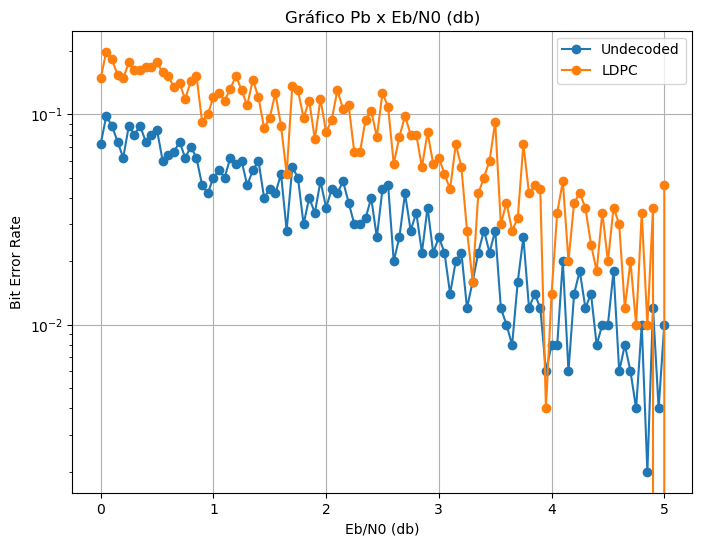

In [10]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(8, 6))

# Plotando os dados
plt.plot(dbs, undecodedErros, marker='o', label='Undecoded')
plt.plot(dbs, codedErros, marker='o', label='LDPC')
plt.yscale("log") 

# Configurando o título e os rótulos dos eixos
plt.title('Gráfico Pb x Eb/N0 (db)')
plt.xlabel('Eb/N0 (db)')
plt.ylabel('Bit Error Rate')

# Adicionando a legenda
plt.legend()

# plt.ylim([0.005, 0.1])

# Exibindo o gráfico
plt.grid(True)
plt.show()

In [11]:
# ldpc = LDPC_Gauss.LDPC(99, 6, 9)
# canalGauss = LDPC_Gauss.CanalGauss(2)
# v = [0]*99
# r = canalGauss.canal(v)
# c = [0 if r[i] >= 0 else 1 for i in range(len(r))]
# L = canalGauss.LLR(r)
# o = canalGauss.beliefPropagation(r, ldpc.VNodes, ldpc.CNodes)

# len_n = 100000
# def generate1MBits():
#     return [random.randint(0, 1) for _ in range(len_n)]

# def split_into_Nbit_subvectors(bits, N):
#     subvectors = []
#     for i in range(0, len(bits)-N, N):
#         subvectors.append(bits[i:i+N])
#     return subvectors

# bits = generate1MBits()
# subvectorsLDPC = split_into_Nbit_subvectors(bits, 1008)